# Observability Tutorial

This notebook explores **observability** from multiple perspectives:

- Control-theoretic observability matrix (linear case)
- Observability Gramian (controllability dual)
- Nullspace-based tests for individual state observability
- Statistical viewpoint: Cramér–Rao lower bound (CRLB)
- Nonlinear systems and partial observability

It builds on the theory described in the `pykal` documentation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_rank, svd, eigvals, pinv
from scipy.linalg import expm, solve_continuous_are
from sympy import symbols, Matrix, simplify, sin, cos, lambdify, eye
from scipy.integrate import solve_ivp


ModuleNotFoundError: No module named 'sympy'

## 1. Control-Theoretic Observability: Linear Systems
We start with a basic example: a 2D position–velocity system.

In [2]:
A = np.array([[0, 1],
              [0, 0]])
H = np.array([[1, 0]])

n = A.shape[0]
O = np.vstack([H @ np.linalg.matrix_power(A, i) for i in range(n)])
rank_O = matrix_rank(O)

print("Observability matrix O:")
print(O)
print(f"Rank of O = {rank_O} (out of {n}) => {'Observable' if rank_O == n else 'Not Observable'}")


Observability matrix O:
[[1 0]
 [0 1]]
Rank of O = 2 (out of 2) => Observable


## 2. Observability Gramian (Continuous-Time)
The observability Gramian is the solution to:

\[ W_o = \int_0^T e^{A^\top t} H^\top H e^{At} dt \]

In [3]:
T = 5.0
def observability_gramian(A, H, T, dt=0.01):
    G = np.zeros((A.shape[0], A.shape[0]))
    for t in np.arange(0, T, dt):
        eAt = expm(A * t)
        G += (eAt.T @ H.T @ H @ eAt) * dt
    return G

G = observability_gramian(A, H, T)
print("Observability Gramian:")
print(G)
print(f"Rank = {np.linalg.matrix_rank(G)}")


Observability Gramian:
[[ 5.      12.475  ]
 [12.475   41.54175]]
Rank = 2


## 3. Individual State Observability (Nullspace Test)
We compute the nullspace of the observability matrix to identify unobservable directions.

In [4]:
from scipy.linalg import null_space

N = null_space(O)
print("Nullspace of O (unobservable directions):")
print(N)

if N.shape[1] > 0:
    print("Some directions are unobservable.")
else:
    print("All directions are observable.")


Nullspace of O (unobservable directions):
[]
All directions are observable.


## 4. Statistical Observability: CRLB
Given a linear system:

\[ y = Hx + v, \quad v \sim \mathcal{N}(0, R) \]

The CRLB for unbiased estimators is:

\[ \text{Cov}(\hat{x}) \succeq (H^\top R^{-1} H)^{-1} \]

In [5]:
R = 0.01 * np.eye(H.shape[0])
FIM = H.T @ np.linalg.inv(R) @ H

try:
    CRLB = np.linalg.inv(FIM)
    print("CRLB exists. State is statistically observable.")
except np.linalg.LinAlgError:
    print("CRLB does not exist (FIM singular). State not observable.")


CRLB does not exist (FIM singular). State not observable.


## 5. Nonlinear Observability (EKF-style Linearization)
Consider the damped pendulum with unknown state \( x = [\theta, \dot{\theta}] \). We measure only angle \( \theta \).

In [6]:
theta, omega = symbols('theta omega')
x = Matrix([theta, omega])
f = Matrix([omega, -9.81 * sin(theta)])
h = Matrix([theta])

F = f.jacobian(x)
H = h.jacobian(x)

print("Jacobian of dynamics (F):")
display(F)

print("Jacobian of measurement (H):")
display(H)

O_sym = Matrix.vstack(H, H*F)
print("Symbolic Observability Matrix:")
display(simplify(O_sym))


NameError: name 'symbols' is not defined

## Simulated Example: 2D Linear System
We simulate a simple linear time-invariant system and compute:
- Observability matrix
- Observability Gramian
- Nullspace for unobservable directions
- Cramér–Rao Lower Bound (CRLB)


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Discrete-time LTI system
A = np.array([[1.0, 0.1],
              [0.0, 1.0]])
H = np.array([[1.0, 0.0]])
n = A.shape[0]
T = 20

# Observability matrix
O = np.vstack([H @ np.linalg.matrix_power(A, i) for i in range(T)])
print('Observability Matrix O:\n', O)
rank_O = np.linalg.matrix_rank(O)
print(f'Rank of O: {rank_O} (out of {n})')

Observability Matrix O:
 [[1.  0. ]
 [1.  0.1]
 [1.  0.2]
 [1.  0.3]
 [1.  0.4]
 [1.  0.5]
 [1.  0.6]
 [1.  0.7]
 [1.  0.8]
 [1.  0.9]
 [1.  1. ]
 [1.  1.1]
 [1.  1.2]
 [1.  1.3]
 [1.  1.4]
 [1.  1.5]
 [1.  1.6]
 [1.  1.7]
 [1.  1.8]
 [1.  1.9]]
Rank of O: 2 (out of 2)


In [8]:
# Observability Gramian (discrete-time)
W = sum([np.linalg.matrix_power(A.T, i) @ H.T @ H @ np.linalg.matrix_power(A, i) for i in range(T)])
print('Observability Gramian W:\n', W)

# Eigenvalues and condition number
eigvals = np.linalg.eigvalsh(W)
print('Eigenvalues of W:', eigvals)
print('Condition number:', np.linalg.cond(W))

Observability Gramian W:
 [[20.  19. ]
 [19.  24.7]]
Eigenvalues of W: [ 3.20522264 41.49477736]
Condition number: 12.945989081207369


In [9]:
# Nullspace of O to check unobservable directions
from scipy.linalg import null_space
null_O = null_space(O)
print(f'Null space dimension: {null_O.shape[1]}')
if null_O.shape[1] > 0:
    print('Unobservable direction(s):')
    print(null_O)

Null space dimension: 0


In [10]:
# Cramér–Rao Lower Bound: inverse of the Gramian (if invertible)
if np.linalg.matrix_rank(W) == n:
    CRLB = np.linalg.inv(W)
    print('Cramér–Rao Lower Bound (CRLB):\n', CRLB)
else:
    print('W is not full rank; CRLB not defined.')

Cramér–Rao Lower Bound (CRLB):
 [[ 0.18571429 -0.14285714]
 [-0.14285714  0.15037594]]


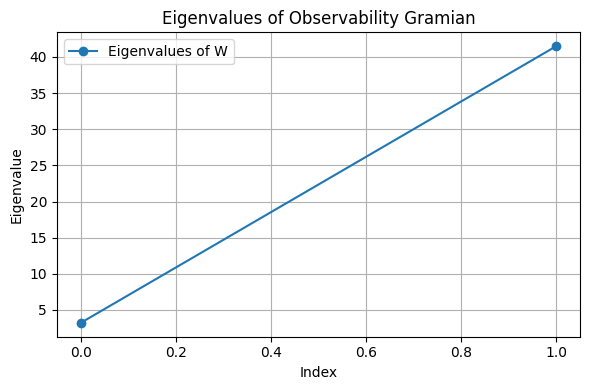

In [11]:
# Plot observability Gramian eigenvalues
plt.figure(figsize=(6, 4))
plt.plot(eigvals, 'o-', label='Eigenvalues of W')
plt.title('Eigenvalues of Observability Gramian')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()